In [1]:
from Helpers import helpers
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plain_df, private_df = helpers.load_plain_and_perturbed_dataset(2, '../export/plain.csv', '../export/')
plain_df['isPrivate'] = False
private_df['isPrivate'] = True
plain_df.head()

,X,Y,isPrivate
0,0.914339,4.550146,False
1,-1.930380,2.702150,False
2,1.872718,4.180692,False
3,-0.555524,4.695958,False
4,-1.034436,8.259404,False


In [2]:
combined_df = pd.concat([plain_df, private_df], ignore_index=True)
combined_df.head()

,X,Y,isPrivate
0,0.914339,4.550146,False
1,-1.930380,2.702150,False
2,1.872718,4.180692,False
3,-0.555524,4.695958,False
4,-1.034436,8.259404,False


In [3]:
from scipy.spatial.distance import cdist
from scipy.spatial import cKDTree

def generate_2d_meshgrid(X, grid_size=12):
    mesh = [np.linspace(X[:, i].min(), X[:, i].max(), num=grid_size) for i in range(X.shape[1])]
    meshgrid = np.meshgrid(*mesh, indexing='ij')
    return meshgrid

def remap_points(perturbed_df, plain_df, meshgrid):
     # Create a KDTree from dataset2
    tree = cKDTree(plain_df)

    # Query the KDTree with dataset1 to find the closest points in dataset2
    _, closest_indices = tree.query(perturbed_df)

    # Calculate the distances between dataset1 and closest points in dataset2
    distances = np.linalg.norm(perturbed_df - plain_df[closest_indices], axis=1)

    # Reshape the meshgrid array
    meshgrid_reshaped = np.stack(meshgrid, axis=-1)

    # Create a KDTree from meshgrid
    meshgrid_tree = cKDTree(meshgrid_reshaped.reshape(-1, meshgrid_reshaped.shape[-1]))

    # Query the KDTree with dataset1 to find the closest points in meshgrid
    _, closest_meshgrid_indices = meshgrid_tree.query(perturbed_df)

    # Calculate the distances between dataset1 and closest points in meshgrid
    meshgrid_distances = np.linalg.norm(perturbed_df - meshgrid_reshaped.reshape(-1, meshgrid_reshaped.shape[-1])[closest_meshgrid_indices], axis=1)

    # Check if each point in dataset1 is within the domain of dataset2
    in_domain = np.logical_and.reduce([np.logical_and(perturbed_df[:, dim] >= plain_df[:, dim].min(), perturbed_df[:, dim] <= plain_df[:, dim].max()) for dim in range(perturbed_df.shape[1])])

    # Create a mask for points outside the domain of dataset2
    outside_domain_mask = np.logical_not(in_domain)

    # Create a mask for points outside the domain and closer to meshgrid points
    outside_domain_and_closer_mask = np.logical_and(outside_domain_mask, meshgrid_distances < distances)

    # Remap points outside the domain and closer to meshgrid points to the closest meshgrid points
    remapped_dataset = perturbed_df.copy()
    remapped_dataset[outside_domain_and_closer_mask] = meshgrid_reshaped.reshape(-1, meshgrid_reshaped.shape[-1])[closest_meshgrid_indices][outside_domain_and_closer_mask]

    return remapped_dataset



def plot_2d_meshgrid(ax, meshgrid):
    x, y = meshgrid
    c = np.ones_like(x)
    #ax.plot(meshgrid[0], meshgrid[1], 'o', color='black', alpha=0.5)
    ax.pcolormesh(x, y, c, facecolor='none', edgecolor='k')


In [4]:
grid = generate_2d_meshgrid(plain_df.drop(columns=['isPrivate']).values, grid_size=12)

In [5]:
#_, points_outside_domain = remap_points(private_df.iloc[:, :2].values, plain_df.iloc[:, :2].values, grid)
#points_outside_domain

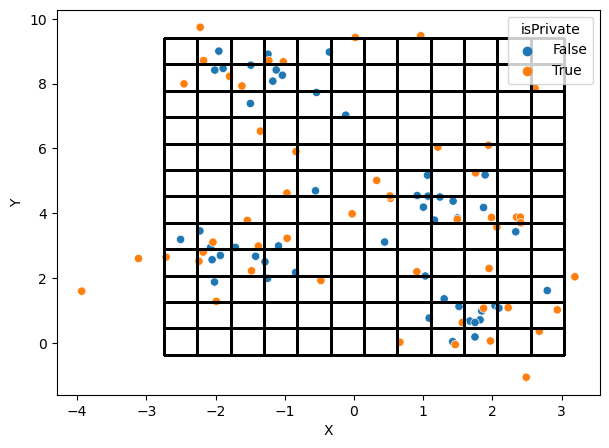

In [6]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.scatterplot(data=combined_df, x='X', y='Y', ax=ax, hue='isPrivate')
plot_2d_meshgrid(ax, grid)

In [7]:
combined_df.shape

(100, 3)

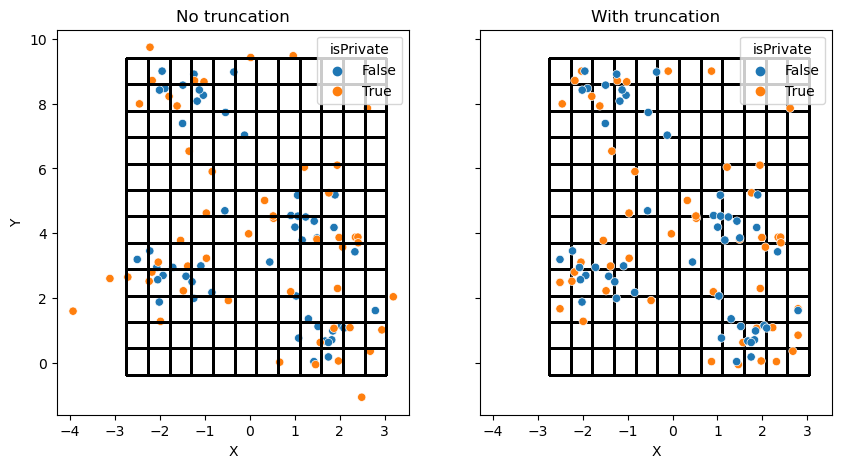

In [9]:
grid = np.array(grid)

fig, ax = plt.subplots(1, 2, figsize=(10, 5),sharex=True, sharey=True)
ax[0].set_title('No truncation')
ax[1].set_title('With truncation')
plot_2d_meshgrid(ax[1], grid)
remapped_dataset = helpers.truncate_n_dimensional_laplace_noise(private_df.iloc[:, :2].values, plain_df.iloc[:, :2].values, grid_size=12)
remapped_dataset = pd.DataFrame(remapped_dataset, columns=['X', 'Y'])
remapped_dataset['isPrivate'] = True
sns.scatterplot(data=pd.concat([remapped_dataset, plain_df]), x='X', y='Y', ax=ax[1], hue='isPrivate')
sns.scatterplot(data=combined_df, x='X', y='Y', ax=ax[0], hue='isPrivate')
plot_2d_meshgrid(ax[0], grid)

fig.savefig('remap.png')